In [1]:
import numpy as np
import cv2
from skimage.feature import hog
from skimage.transform import resize as imresize
import matplotlib.pyplot as plt
import joblib
import matplotlib.image as mpimg
import pandas as pd
import glob
from sklearn.preprocessing import StandardScaler
from skimage.io import imread
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
IMG = imread('test_images/test1.jpg')

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    out_img = np.copy(img)
    for b in bboxes:
        cv2.rectangle(out_img, *b, color, thick)
    return out_img

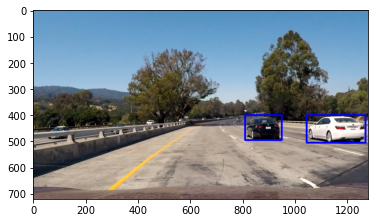

In [3]:
bboxes = [((810,400),(950,495)),((1045,400),(1270,505))]
plt.imshow(draw_boxes(IMG, bboxes=bboxes));

In [4]:
def extract_features(imgs, cspace='RGB', size = (64,64)):
    features = []
    for filename in imgs:
        image = imread(filename)
        if size != (64,64):
            image = cv2.resize(image, size)
        features.append(
            np.ravel(
                cv2.HOGDescriptor((64,64), (16,16), (8,8), (8,8), 9) \
                    .compute(get_feature_space(image, cspace))
            )
        )
    return features

In [5]:
def get_feature_space(img, cspace):
    if cspace != 'RGB':
        if cspace == 'HLS':
            features = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YCrCb':
            features = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        elif cspace == 'HSV':
            features = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            features = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'YUV':
            features = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'Lab':
            features = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
        return features

def get_hog_features(img, cspace):
    return np.ravel(
        cv2.HOGDescriptor((64,64), (16,16), (8,8), (8,8), 9) \
            .compute(get_feature_space(img, cspace))
    )

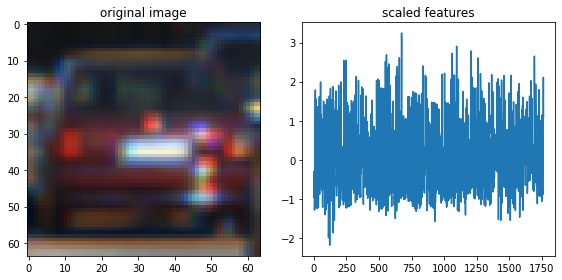

In [6]:
cv2.HOGDescriptor((64,64), (8,8), (8,8), (8,8), 9).compute(IMG).shape
vehicles = glob.glob('vehicles/*/*.png')
non_vehicles = glob.glob('non-vehicles/*/*.png')
vehicle_features = extract_features(vehicles, cspace='YUV')
non_vehicle_features = extract_features(non_vehicles, cspace='YUV')

def plot_features(vehicle_features, non_vehicle_features):
    vehicle_features[0].shape
    if len(vehicle_features) > 0:
        X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)                        
        X_scaler = StandardScaler().fit(X)
        scaled_X = X_scaler.transform(X)
        vehicle_ind = np.random.randint(0, len(vehicles))
        fig = plt.figure(figsize=(12,4))
        plt.subplot(131)
        plt.imshow(mpimg.imread(vehicles[vehicle_ind]))
        plt.title('original image')
        plt.subplot(132)
        plt.plot(scaled_X[vehicle_ind])
        plt.title('scaled features')
        fig.tight_layout()
        return scaled_X, X_scaler
    else:
        pass
scaled_X, X_scaler = plot_features(vehicle_features, non_vehicle_features)   

In [7]:
labels = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, labels, test_size=0.2, random_state=4000)

In [8]:
svc = LinearSVC()
svc.fit(X_train, y_train)
print('SVC results')
print('accuracy on training data: ', svc.score(X_train, y_train))
print('accuracy on test data: ', svc.score(X_test, y_test))
prediction = svc.predict(X_test[0].reshape(1, -1))

C:\Users\batt\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


SVC results
accuracy on training data:  1.0
accuracy on test data:  0.9552364864864865


In [9]:
mlp = MLPClassifier(random_state=999)
mlp.fit(X_train, y_train)
print('MLP results')
print('accuracy on training data: ', mlp.score(X_train, y_train))
print('accuracy on test data: ', mlp.score(X_test, y_test))
prediction = mlp.predict(X_test[0].reshape(1, -1))

MLP results
accuracy on training data:  1.0
accuracy on test data:  0.9926801801801802


In [10]:
joblib.dump(mlp, 'mlp1.pkl')
joblib.dump(X_scaler, 'scaler1.pkl')
mlp = joblib.load('mlp1.pkl')
X_scaler = joblib.load('scaler1.pkl')

In [11]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    nx_windows = np.int(xspan/nx_pix_per_step) 
    ny_windows = np.int(yspan/ny_pix_per_step)
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = (xs+1)*nx_pix_per_step + x_start_stop[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = (ys+1)*ny_pix_per_step + y_start_stop[0]
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

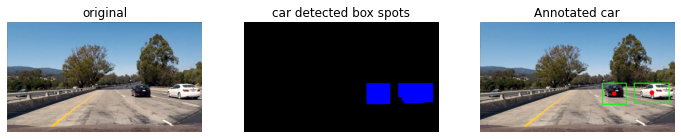

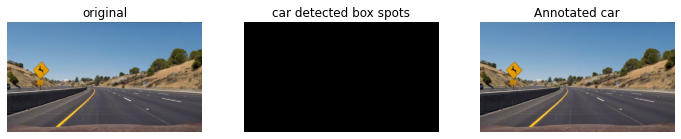

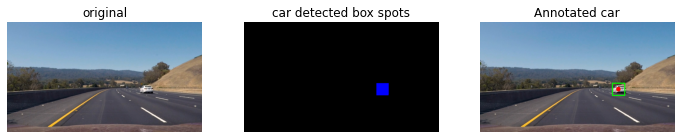

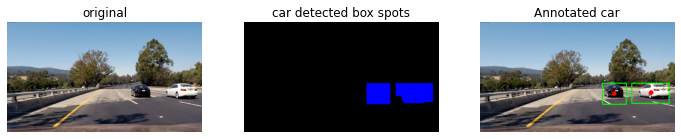

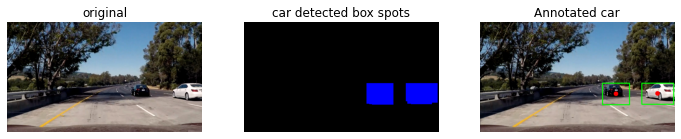

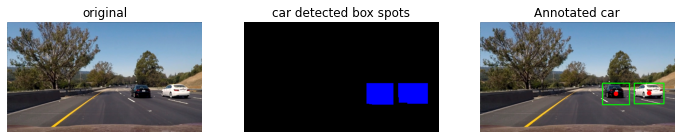

In [12]:
def annotate_img(path):
    #reference https://github.com/JustinHeaton/Vehicle-Detection
    image = imread(path)
    detected_vehicles = []
    pxs = 320
    INCREMENT_SIZE_BY = 16
    PXS_LIMIT = 720
    y_start_stop = [400, 660]
    xy_overlap = (0.8, 0.8)
    ACCEPTANCE_THRESHOLD = .99
    
    while pxs < PXS_LIMIT:
        windows = slide_window(
            image, 
            x_start_stop = [None, None], 
            y_start_stop = y_start_stop, 
            xy_window = (pxs, pxs), 
            xy_overlap = xy_overlap
        )  
        for window in windows:
            features = []
            resized = cv2.resize((image[window[0][1]: window[1][1], window[0][0]: window[1][0]]),(64,64))
            hog_features = get_hog_features(resized,cspace='YUV')
            hog_features=hog_features.reshape(1,-1)
            x_scaled = X_scaler.transform(hog_features)
            
            if resized.shape[0] > 0:
                if mlp.predict_proba(x_scaled.reshape(1,-1))[0][1] > ACCEPTANCE_THRESHOLD:
                    detected_vehicles.append(window)
        pxs += INCREMENT_SIZE_BY
        
    out = np.copy(image)
    boxes = draw_boxes(np.zeros_like(image), bboxes=detected_vehicles, thick=-1)
    contours,_ = cv2.findContours(
        boxes[:,:,2].astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE
    )
    
    for countour in contours:
        rect_color_tup = (0,255,0)
        x, y, width, height = cv2.boundingRect(countour)
        cv2.rectangle(out, (x, y), (x + width, y + height), rect_color_tup, 6)
        moments = cv2.moments(countour)
        cv2.circle(
            out, (
                int(moments['m10'] / moments['m00']), int(moments['m01'] / moments['m00'])
            ), 15, (255, 0, 0), -1
        )
    f, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(10,6))
    f.tight_layout()
    ax1.axis('off')
    ax1.set_title('original')
    ax1.imshow(image)
    ax2.axis('off')
    ax2.set_title('car detected box spots')
    ax2.imshow(boxes, cmap='hot')
    ax3.axis('off')
    ax3.set_title('Annotated car')
    ax3.imshow(out)
    
for image in glob.glob('test_images/*.jpg'):
    annotate_img(image);

In [13]:
from collections import deque
class boxes:
    def __init__(self):
        self.detections = deque(maxlen=12)

In [14]:
def process_vid(image):
    detected_vehicles = [] 
    pxs = 320
    PXS_LIMIT = 720
    y_start_stop = [400, 660]
    xy_overlap = (0.8, 0.8)
    ACCEPTANCE_THRESHOLD = .99
    INCREMENT_PXS_BY = 16
    while pxs < PXS_LIMIT:
        windows = slide_window(
            image, 
            x_start_stop=[640, None], 
            y_start_stop=y_start_stop, 
            xy_window=(pxs, pxs), 
            xy_overlap=xy_overlap
        )  
        for w in windows:
            features = []
            resized = cv2.resize(
                (
                    image[w[0][1]: w[1][1], w[0][0]: w[1][0]]
                ),(64,64)
            )
            
            hf = get_hog_features(resized, cspace='YUV')
            hf=hf.reshape(1,-1)
            x_scaled = X_scaler.transform(hf)
            if resized.shape[0] > 0:
                if mlp.predict_proba(x_scaled.reshape(1,-1))[0][1] > ACCEPTANCE_THRESHOLD:
                    detected_vehicles.append(w)
        pxs += INCREMENT_PXS_BY
        
    out = np.copy(image).astype('uint8')
    boxes = draw_boxes( np.zeros_like(image), bboxes=detected_vehicles, thick=-1)
    rects_arr = []
    contours, _ = cv2.findContours(
        boxes[:,:,2].astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE
    )
    for contour in contours:
        x, y, width, height = cv2.boundingRect(contour)
        rects_arr.append([x, y, x + width, y + height])
    Boxes.detections.append(rects_arr)
    boxes = []
    combined = np.ravel(np.array(Boxes.detections))
    for i in range(len(combined)):
        boxes.extend(np.ravel(combined[i]))
    bb = []
    i = 0
    while i <= len(boxes)-3:
        bb.append(boxes[i:i+4])
        i += 4
    rects, _ = cv2.groupRectangles(np.array(bb).tolist(), 10,.1)
    for r in rects:
        cv2.rectangle(out, (r[0], r[1]), (r[2],r[3]), (0,255,0), 5)
    return out

In [15]:
cap=cv2.VideoCapture('project_video.mp4')

In [16]:
Boxes=boxes()
while(cap.isOpened()):
    ret,frame=cap.read()
    frame=process_vid(frame)
    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

In [2]:
np.__version__

'1.18.0'